# Import libraries

In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset

In [2]:
with zipfile.ZipFile('../input/facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall('train')
    
with zipfile.ZipFile('../input/facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')
    

In [3]:
train_data = 'train/training.csv'
test_data = 'test/test.csv'
lookid_data = '../input/facial-keypoints-detection/IdLookupTable.csv'

train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)
lookid_df = pd.read_csv(lookid_data)


# Data Analysis

In [4]:
print(len(train_df))

train_df.head(10).T

7049


,0,1,2,3,4,5,6,7,8,9
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159,76.8982,69.0266,75.5916,72.953,71.272
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845,41.1719,34.29,40.0382,35.8995,37.2903
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824,36.401,34.7617,37.4782,36.3424,36.3446
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949,39.3676,33.714,40.4548,37.0432,39.4905


In [5]:
print(train_df.isnull().values.ravel().sum())
print(len(train_df.dropna()))
# train_df = train_df.dropna()
print(len(train_df))
train_df.fillna(method= 'ffill', inplace= True)

105412
2140
7049


In [6]:
print(len(test_df))
print(test_df.isnull().values.ravel().sum())
test_df.head(10)

1783
0


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
5,6,177 177 177 171 142 115 97 84 89 90 88 82 63 5...
6,7,77 55 44 56 58 61 67 66 65 65 65 73 72 78 86 9...
7,8,156 160 162 166 150 114 97 105 125 127 119 121...
8,9,230 230 231 231 231 231 231 231 231 229 214 20...
9,10,132 129 126 128 146 163 170 169 143 101 71 55 ...


## Prepare Training Data

In [7]:

train_data = []

for image in train_df['Image'].values:
    img = image.split(' ')
    image_array = [0.0 if '' == img[i] else float(img[i]) for i in range(len(img))]
    train_data.append(image_array)
    


train_labels = train_df.drop('Image', axis= 1).to_numpy(dtype= np.float32)


train_data = np.asarray(train_data, np.float32)
train_data = train_data.reshape(-1, 96, 96, 1)

print(train_data.shape)
print(train_labels.shape)



(7049, 96, 96, 1)
(7049, 30)


# Data Preprocessing

## 1. Histogram Equilization

In [9]:
eq_image_list = []
eq_keypoint_list = []
for i in range(len(train_data)):
    eq_image = cv2.equalizeHist((train_data[i]).astype(np.uint8).reshape(96, 96))
    eq_image_list.append(eq_image.reshape(96, 96, 1))
    eq_keypoint_list.append(train_labels[i])
    
train_data = np.concatenate((train_data, np.asarray(eq_image_list, np.float32)), axis= 0)
train_labels = np.concatenate((train_labels, np.asarray(eq_keypoint_list, np.float32)), axis= 0)
print(train_data.shape)
print(train_labels.shape)


(14098, 96, 96, 1)
(14098, 30)


## 2. Data Augmentation by Horizontal Flipping

In [10]:
def horizontal_flip(image, keypoint):
    flipped_image = np.flip(image, axis= 1)
    flipped_keypoint = [(image.shape[0] - keypoint[i]) if (i % 2 == 0) else keypoint[i] for i in range(len(keypoint))]
    return flipped_image, np.asarray(flipped_keypoint, dtype= np.float32)

flipped_image_list = []
flipped_keypoint_list = []
for i in range(train_data.shape[0]):
    flipped_image, flipped_keypoint = horizontal_flip(train_data[i], train_labels[i])
    flipped_image_list.append(flipped_image)
    flipped_keypoint_list.append(flipped_keypoint)
    


In [11]:
train_data = np.concatenate((train_data, flipped_image_list), axis= 0)
train_labels = np.concatenate((train_labels, np.asarray(flipped_keypoint_list, np.float32)), axis= 0)
print(train_data.shape)
print(train_labels.shape)

(28196, 96, 96, 1)
(28196, 30)


## Split Data

In [12]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=2)
print(train_data.shape)
print(val_data.shape)

(22556, 96, 96, 1)
(5640, 96, 96, 1)


# Data Visualization

## 1. Train Data

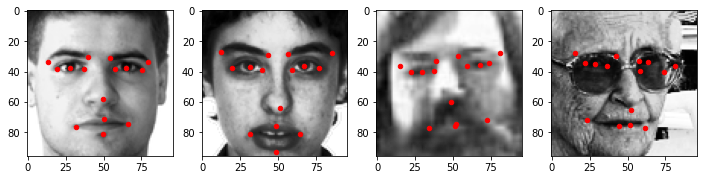

In [14]:
index = np.random.randint(len(train_data), size=(4))
fig, axis = plt.subplots(1, 4, figsize= (12, 6))
for i, ax in zip(index, axis):
    ax.imshow(train_data[i].reshape(96, 96), cmap= 'gray')
    ax.scatter(train_labels[i][0::2], train_labels[i][1::2], marker='o',color= 'red', s=20)

## 2. Validation Data

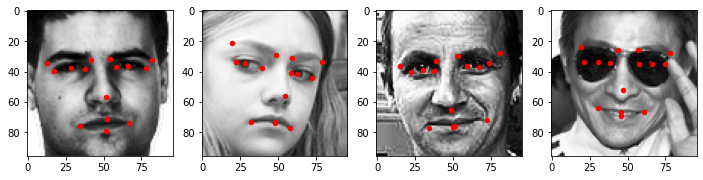

In [18]:
index = np.random.randint(len(val_data), size=(4))
fig, axis = plt.subplots(1, 4, figsize= (12, 6))
for i, ax in zip(index, axis):
    ax.imshow(val_data[i].reshape(96, 96), cmap= 'gray')
    ax.scatter(val_labels[i][0::2], val_labels[i][1::2], marker='o',color= 'red', s=20)

# Prepare Test Data

In [19]:
test_df.isnull().values.ravel().sum()
test_data = []
for image in test_df['Image'].to_numpy():
    img = image.split(' ')
    image_array = [0 if img[i] == '' else float(img[i])/255.0 for i in range(len(img))]
    test_data.append(image_array)


test_data = np.asarray(test_data, np.float32)
test_data = train_data.reshape(-1, 96, 96, 1)
test_data.shape


(22556, 96, 96, 1)

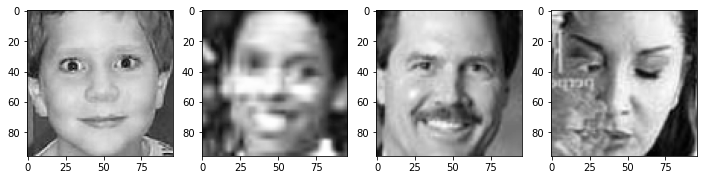

In [20]:
index = np.random.randint(len(test_data), size=(4))
fig, axis = plt.subplots(1, 4, figsize= (12, 6))
for i, ax in zip(index, axis):
    ax.imshow(test_data[i].reshape(96, 96), cmap= 'gray')


# Build Model

In [39]:


model = keras.Sequential(
    
[
    keras.layers.Conv2D(32, (3, 3), padding= 'same', use_bias=False, input_shape= (96, 96, 1)),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    
    keras.layers.Conv2D(32, (3, 3), padding= 'same', use_bias=False, input_shape= (96, 96, 1)),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(), 
     
    
    keras.layers.Conv2D(64, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    keras.layers.MaxPooling2D(2, 2),
    
    
    keras.layers.Conv2D(64, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(96, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 

    
    keras.layers.Conv2D(96, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(128, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(128, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    
    keras.layers.Conv2D(256, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(256, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(512, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),
    
    keras.layers.Conv2D(512, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(512, activation= 'relu'),
    keras.layers.Dropout(0.1),
        
    keras.layers.Dense(30),
    
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 48, 48, 32)       

# Compile Model

In [40]:
model.compile(
    optimizer= 'adam',
    loss = 'mse',
    metrics = ['mae'],
             )

In [41]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(test_data.shape)


(22556, 96, 96, 1)
(22556, 30)
(5640, 96, 96, 1)
(22556, 96, 96, 1)


# Train Model

In [42]:
history = model.fit(
    train_data,
    train_labels,
    epochs= 50,
    validation_data= (val_data, val_labels),
    batch_size= 128,
)

Epoch 1/50
177/177 [==============================] - 12s 70ms/step - loss: 381.6223 - mae: 13.4000 - val_loss: 251.1264 - val_mae: 11.9415
Epoch 2/50
177/177 [==============================] - 12s 68ms/step - loss: 196.0873 - mae: 9.8550 - val_loss: 232.1065 - val_mae: 11.2210
Epoch 3/50
177/177 [==============================] - 12s 68ms/step - loss: 193.4344 - mae: 9.7234 - val_loss: 188.4125 - val_mae: 9.4744
Epoch 4/50
177/177 [==============================] - 12s 69ms/step - loss: 190.9446 - mae: 9.5716 - val_loss: 202.9327 - val_mae: 10.2704
Epoch 5/50
177/177 [==============================] - 12s 68ms/step - loss: 189.5142 - mae: 9.4783 - val_loss: 184.5656 - val_mae: 9.1584
Epoch 6/50
177/177 [==============================] - 12s 68ms/step - loss: 187.4624 - mae: 9.3442 - val_loss: 182.6013 - val_mae: 9.0061
Epoch 7/50
177/177 [==============================] - 12s 68ms/step - loss: 186.3019 - mae: 9.2959 - val_loss: 185.9864 - val_mae: 9.3090
Epoch 8/50
177/177 [==========

## Save Model

In [43]:
model.save('facial_keyPoint_detection.h5')

# Training Graph Visualization

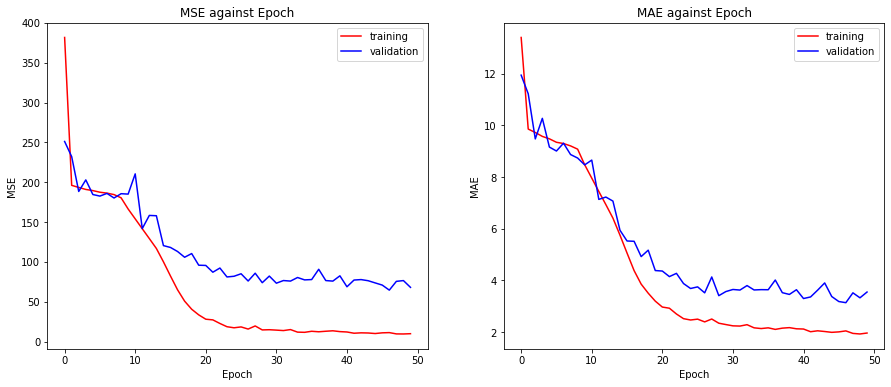

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(loss))

fig, ((ax1,ax2)) = plt.subplots(1, 2,figsize=(15,6), sharex=True, sharey=False)

ax1.plot(epoch, loss, 'r', label= 'training')
ax1.plot(epoch, val_loss, 'b', label= 'validation')
ax1.set_title('MSE against Epoch')
ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')

ax2.plot(epoch, mae, 'r', label= 'training')
ax2.plot(epoch, val_mae, 'b', label= 'validation')
ax2.set_title('MAE against Epoch')
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('MAE')

fig.savefig('graph.png')


# Prediction on Test Data

In [45]:
test_labels = model.predict(test_data)
test_labels.shape

(22556, 30)

# Visualize Prediction

[4614, 1455, 3028, 2075]


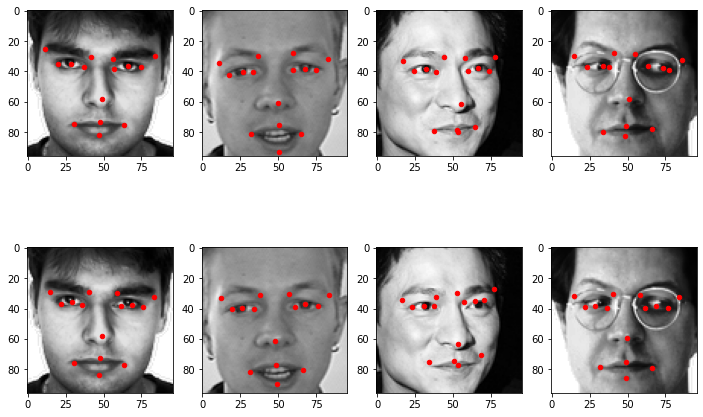

In [80]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(2, 4, figsize= (12, 8))
length = val_data.shape[0]
index = np.random.randint(length, size= (4))
val_labels_pred = model.predict(val_data)

for j in range(4):
    axis[0, j].imshow(val_data[index[j]].reshape(96, 96), cmap= 'gray')
    axis[0, j].scatter(val_labels[index[j]][::2], val_labels[index[j]][1::2], marker='o',color= 'red', s=20)
    axis[1, j].imshow(val_data[index[j]].reshape(96, 96), cmap= 'gray')
    axis[1, j].scatter(val_labels_pred[index[j]][::2], val_labels_pred[index[j]][1::2], marker='o',color= 'red', s=20)
    
fig.savefig('vis_data.png')

# Preparing for Submission

In [ ]:
lookid_list = list(lookid_df['FeatureName'])
imageID = list(lookid_df['ImageId']-1)
pre_list = list(test_labels)

rowid = lookid_df['RowId']
rowid=list(rowid)

feature = []
for f in list(lookid_df['FeatureName']):
    feature.append(lookid_list.index(f))
    
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('face_keypoint_detection_sub.csv',index = False)